In [1]:
import sys
print(sys.version)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import StandardScaler

In [3]:
class DatasetReader:
    def __init__(self, filename: str = "dataset/dataset.csv", is_colab: bool = True):
        self.filename = filename
        self.repo_name = 'GSoC_HSF_ATLAS/'
        self.filepath = repo_name + filename if is_colab else filename
        self.cols = ["event_ID", "process_ID", "event_weight", "MET", "MET_Phi"]
        self.ignore_particles = ["e-", "e+", "m-", "m+", "g", "b"]
        self.data_list = []

    def readFile(self) -> List[List[str]]:
        print("Opening file: " + self.filepath)
        file = open(self.filepath, "r")

        print("Reading file line by line...")
        for line in file.readlines():
            cleaned_line = line.replace(";", ",")
            cleaned_line = cleaned_line.rstrip(",\n")
            cleaned_line = cleaned_line.split(",")
            self.data_list.append(cleaned_line)
        return self.data_list

    def createDataFrame(self):
        longest_line = max(self.data_list, key=len)

        n_max_cols = len(longest_line)
        print("Number of maximum possible columns: " + str(n_max_cols))

        print("Our cols are: " + str(self.cols))
        print("Creating deep copy of cols")
        copy_cols = self.cols.copy()

        for i in range(1, (int((n_max_cols - 5) / 5)) + 1):
            self.cols.append("obj_" + str(i))
            self.cols.append("E_" + str(i))
            self.cols.append("pt_" + str(i))
            self.cols.append("eta_" + str(i))
            self.cols.append("phi_" + str(i))

        print("Number of cols: " + str(len(self.cols)))
        print("\nSlicing list of cols: " + str(self.cols[50:60]))

        df = pd.DataFrame(self.data_list, columns=self.cols)
        df.fillna(value=np.nan, inplace=True)

#         return df
        df_data = pd.DataFrame(df.values, columns=self.cols)
        df_data.fillna(value=0, inplace=True)
        df_data.drop(columns=copy_cols, inplace=True)

        ignore_list = []
        for i in range(len(df_data)):
            for j in df_data.loc[i].keys():
                if "obj" in j:
                    if df_data.loc[i][j] in self.ignore_particles:
                        ignore_list.append(i)
                        break

        df_data.drop(ignore_list, inplace=True)

        x = df_data.values.reshape([df_data.shape[0] * df_data.shape[1] // 5, 5])

        temp_list = []
        for i in range(x.shape[0]):
            if (x[i] == 0).all():
                temp_list.append(i)        
        x1 = np.delete(x, temp_list, 0)
        del x

        temp_list = []
        for i in range(x1.shape[0]):   
            if  (x1[i][0] == 'j'):
                continue
            else:
                temp_list.append(i)
                print(i, x1[i][0])
        
        data = np.delete(x1, temp_list, 0)

        col_names = ['obj', 'E', 'pt', 'eta', 'phi']
        data_df = pd.DataFrame(data, columns=col_names)
        # Drop the 'obj' column as it's unnecessary
        data_df.drop(columns='obj', inplace=True)
        data_df = data_df.astype('float32')

        return data_df

In [4]:
dr = DatasetReader(is_colab = False)
data = dr.readFile()
df = dr.createDataFrame()

Opening file: dataset/dataset.csv
Reading file line by line...
Number of maximum possible columns: 65
Our cols are: ['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi']
Creating deep copy of cols
Number of cols: 65

Slicing list of cols: ['obj_10', 'E_10', 'pt_10', 'eta_10', 'phi_10', 'obj_11', 'E_11', 'pt_11', 'eta_11', 'phi_11']


In [6]:
df.to_csv('dataset/cleaned.csv', index=False)

In [18]:
df_normalized = df.copy()
df_normalized[df_normalized.columns] = StandardScaler().fit_transform(df_normalized)

In [19]:
print(df.head())
print(df_normalized.head())

              E             pt       eta       phi
0  1.069460e+06  751597.000000  0.858186 -1.842170
1  4.576470e+05  110079.000000  2.102870  2.175010
2  4.964910e+04   30875.199219 -1.031890 -1.799200
3  6.760000e+05  640429.000000  0.330450  0.704554
4  1.239300e+06  602104.000000  1.343240 -0.550856
          E        pt       eta       phi
0  1.467948  1.881091  0.567717 -1.014441
1  0.042805 -0.502422  1.397870  1.210629
2 -0.907576 -0.796698 -0.692885 -0.990640
3  0.551431  1.468054  0.215739  0.396160
4  1.863569  1.325661  0.891228 -0.299197


In [20]:
def plot_hist(data_df: pd.DataFrame(), savefig: bool = False, folderName: str = "images"):
    unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

    branches=["pt","eta","phi","E"]

    n_bins = 100

    for kk in range(0,4):
        n_hist_data, bin_edges, _ = plt.hist(df_normalized[branches[kk]], color='blue', label='Input', alpha=1, bins=n_bins)
        plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
        plt.ylabel('# of events')
        if savefig:
            plt.savefig(folderName + "/four_momentum_"+branches[kk],dpi=300)
        plt.show()

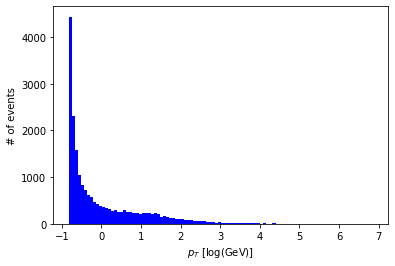

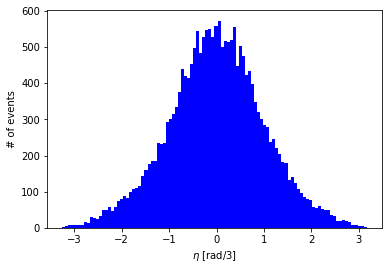

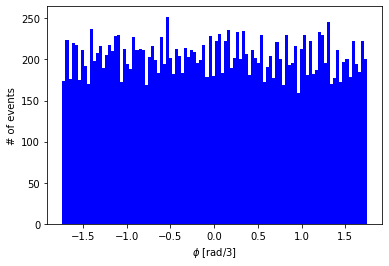

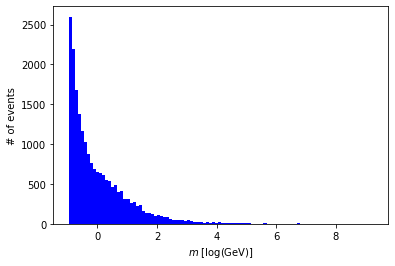

In [21]:
plot_hist(df_normalized, True)